In [425]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

from src.Tools import portfolio_metrics
from qiskit_src.ansatz import CP_QAOA, qubo_cost, Grid
from qiskit_src.tools import get_qubo, min_cost_partition, normalized_cost

In [426]:
N=9
k=5
seed=1
alpha=0.001
layers=2
max_iter=300

w_z_phase = False
w_grid = False
w_next_nearest_neighbors = False
w_evenly_distributed = True


In [427]:
if w_grid:
    my_grid = Grid(N_qubits=N)

In [428]:
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

max_cost, min_cost, min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
min_state_str = ''.join([str(_) for _ in min_state])
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances,
                     alpha=alpha,
                     lmbda=lmbda,
                     k=k)

In [429]:
ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 grid=my_grid if w_grid else None,
                 QUBO_matrix=Q,
                 QUBO_offset=offset,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_evenly_distributed_start_x=w_evenly_distributed,
                 with_z_phase=w_z_phase)

# Initial guess for parameters (gamma, beta) of circuit
theta_min, theta_max = -2*np.pi, 2*np.pi
if w_grid:
    N_xx_yy_angles = layers * len(my_grid.get_NN_indices())
else:
    N_xx_yy_angles = layers * (N - 1) 
if w_next_nearest_neighbors:
    N_xx_yy_angles += layers * (N - 2)
if w_z_phase:
    N_xx_yy_angles += N * layers
theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_xx_yy_angles)

_available_methods_ = ['COBYLA', 'Nelder-Mead']
_method_idx_ = 0

costs = []
angles = []
best_state_probs = []
def callback_function(x):
    _dict_ = ansatz.get_state_probabilities(angles=x, flip_states=False)
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=max_cost, 
                             min_cost=min_cost)
    if min_state_str in list(_dict_.keys()):
        best_state_probs.append(_dict_[min_state_str])
    else:
        best_state_probs.append(0)
    costs.append(_cost_)
    angles.append(x)


res = sc.optimize.minimize(fun=ansatz.get_cost, x0=theta_i,
                           method=_available_methods_[_method_idx_],
                           options={'disp': False, 'maxiter': max_iter},
                           callback=callback_function)


_dict_ = ansatz.get_state_probabilities(angles=angles[np.argmin(costs)], flip_states=False)

res.status

1

In [430]:
res.message, res

('Optimization terminated successfully.',
  message: Optimization terminated successfully.
  success: True
   status: 1
      fun: -0.11778045613043929
        x: [-4.016e+00  6.911e+00 ...  5.512e+00  2.135e+00]
     nfev: 212
    maxcv: 0.0)

Text(0, 0.5, 'Optimal state probability')

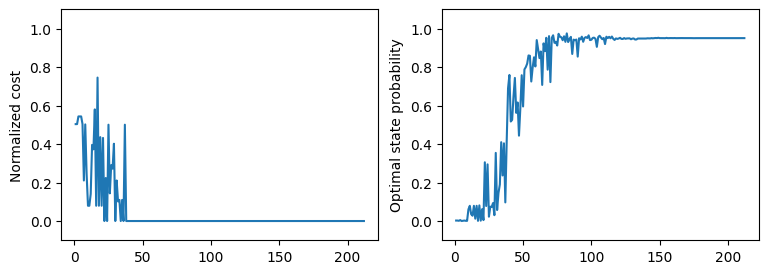

In [431]:
fig, ax = plt.subplots(1,2,figsize=(9,3))
Y = costs
X = [it + 1 for it in range(len(Y))]
ax[0].plot(X,Y)
ax[0].set_ylim(-0.1,1.1)
ax[0].set_ylabel('Normalized cost')

ax[1].plot(X,best_state_probs)
ax[1].set_ylim(-0.1,1.1)
ax[1].set_ylabel('Optimal state probability')